# Testing normalization effect

This notebook implements a test for examining the normalization effect on training.

# Loading Env

In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
colab = True

run_dir = '/content/drive/My Drive/ColabFiles/CifarReconstruct/'

import datetime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
import torch
import torchvision
import numpy as np

if colab == False:
  import caffeine

%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/packages/kornia/
#print("no import kornia.metrics as metrics")
import kornia.metrics as metrics
%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/

# files containing training code
from GetParams import get_args
#from common_utils.common import save_weights
from common_utils.common import now
from common_utils.common import dump_obj_with_dict
from common_utils.common import load_dict_to_obj
from common_utils.common import load_weights

from common_utils.image import get_ssim_all, get_ssim_pairs_kornia

from extraction import get_trainable_params
from extraction import calc_extraction_loss, evaluate_extraction



from CreateModel import create_model

%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/packages/wandb/
print("no import wandb")
#import wandb
%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/

from Main import epoch_ce
from Main import data_extraction

print(torchvision.__version__)
print(torch.__version__)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

/content/drive/My Drive/ColabFiles/CifarReconstruct/packages/kornia
/content/drive/My Drive/ColabFiles/CifarReconstruct
/content/drive/My Drive/ColabFiles/CifarReconstruct/packages/wandb
no import wandb
/content/drive/My Drive/ColabFiles/CifarReconstruct
0.18.1+cu121
2.3.1+cu121
MPS not available because the current PyTorch install was not built with MPS enabled.


In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms
import math


def load_bound_dataset(dataset, batch_size, shuffle=False, start=None, end=None, **kwargs):
    def _bound_dataset(dataset, start, end):
        if start is None:
            start = 0
        if end is None:
            end = len(dataset)
        return torch.utils.data.Subset(dataset, range(start, end))

    dataset = _bound_dataset(dataset, start, end)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=shuffle, **kwargs)


def fetch_cifar10(root, train=False, transform=None, target_transform=None):
    transform = transform if transform is not None else torchvision.transforms.ToTensor()
    dataset = torchvision.datasets.CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=True)
    return dataset


def load_cifar10(root, batch_size, train=False, transform=None, target_transform=None, **kwargs):
    dataset = fetch_cifar10(root, train, transform, target_transform)
    return load_bound_dataset(dataset, batch_size, **kwargs)


def move_to_type_device(x, y, device, verbose = False):
    if verbose: print(f'setting dtype as {torch.get_default_dtype()} from default')
    x = x.to(torch.get_default_dtype())
    y = y.to(torch.get_default_dtype())
    x, y = x.to(device), y.to(device)
    return x, y


def create_labels(y0):
    # airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks
    # 4 subclasses of machines; 6 subclasses of animals
    labels_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
    y0 = torch.stack([torch.tensor(labels_dict[int(cur_y)]) for cur_y in y0])
    return y0


def get_balanced_data(args, data_loader, data_amount, verbose = True):
    if verbose: print('BALANCING DATASET...')
    # get balanced data
    data_amount_per_class = data_amount // 2

    labels_counter = {1: 0, 0: 0}
    sublabels_cnt = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, \
                     5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    nof_vehicl = 4
    nof_animal = 6
    data_amount_per_sub_class_vehicl = math.floor(data_amount / (nof_vehicl * 2))
    data_amount_per_sub_class_animal = math.floor(data_amount / (nof_animal * 2))

    x0, y0 = [], []
    got_enough = False
    for bx, by in data_loader:
        # verify sublabels before mapping to label
        by_multy = create_labels(by)
        for i in range(len(bx)):
            if labels_counter[int(by_multy[i])] < data_amount_per_class and\
                ((int(by_multy[i]) == 0 and sublabels_cnt[int(by[i])] < data_amount_per_sub_class_vehicl) or\
                 (int(by_multy[i]) == 1 and sublabels_cnt[int(by[i])] < data_amount_per_sub_class_animal) or\
                 (int(by_multy[i]) == 0 and\
                  sublabels_cnt[int(0)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(1)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(8)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(9)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(by[i])] <= data_amount_per_sub_class_vehicl) or\
                 (int(by_multy[i]) == 1 and\
                  sublabels_cnt[int(2)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(3)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(4)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(5)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(6)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(7)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(by[i])] <= data_amount_per_sub_class_animal)):

                labels_counter[int(by_multy[i])] += 1
                sublabels_cnt[int(by[i])] += 1
                x0.append(bx[i])
                y0.append(by_multy[i])
            if (labels_counter[0] >= data_amount_per_class) and (labels_counter[1] >= data_amount_per_class):
                got_enough = True
                break
        if got_enough:
            break

    # verify balancness
    balanced = True
    vehicl_cnts = [sublabels_cnt[0],\
                   sublabels_cnt[1],\
                   sublabels_cnt[8],\
                   sublabels_cnt[9],\
                   ]
    animal_cnts = [sublabels_cnt[2],\
                   sublabels_cnt[3],\
                   sublabels_cnt[4],\
                   sublabels_cnt[5],\
                   sublabels_cnt[6],\
                   sublabels_cnt[7],\
                   ]
    labels_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
    if max(vehicl_cnts) - min(vehicl_cnts) > 1 or\
       max(animal_cnts) - min(animal_cnts) > 1:
      print(f'Sub classes not balanced; sub classes labels counters: {sublabels_cnt}')
      print(f'mapping between subclasses to multicalss: {labels_dict}')
      balanced = False
    total_vehicl = sum(vehicl_cnts)
    total_animal = sum(animal_cnts)
    if total_vehicl != data_amount_per_class or\
       total_animal != data_amount_per_class:
      print(f'Super classes not balanced; Vehicles = {total_vehicl}; Animals = {total_animal}; expecting {data_amount_per_class}')
      print(f'Sub classes labels counters: {sublabels_cnt}')
      print(f'mapping between subclasses to multicalss: {labels_dict}')
      balanced = False
    if not balanced:
      print('LOADED UNBALANCED')
    else:
      if verbose: print('OK, BALANCED')

    x0, y0 = torch.stack(x0), torch.stack(y0)
    return x0, y0



In [ ]:
# Setup code
dataset_dir = os.path.join(run_dir, 'dataset')
results_dir = os.path.join(run_dir, 'results')
os.makedirs(os.path.join(run_dir, 'results'), exist_ok=True)


#def setup_args(args, new_run = True, run_name = None, verbose = False):
def setup_args(args, verbose = False):
  # setting device type, and run dir in args
    if verbose: print("setup_args")

    #if args.mps:
    #    mps_device = torch.device("mps")
    #    args.device = torch.device(mps_device if torch.backends.mps.is_available() else 'cpu')
    #else:
    #    args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #if verbose: print(f'DEVICE:     {args.device}')

    args.results_dir  = results_dir
    args.datasets_dir = dataset_dir
    args.model_name = f'{args.problem}_d{args.data_per_class_train}'
    if args.proj_name:
        args.model_name += f'_{args.proj_name}'

    # resolve output_dir
    #if new_run:
    #  import dateutil.tz
    #  timestamp = datetime.datetime.now(dateutil.tz.tzlocal()).strftime('%m_%d_%H_%M_%S')
    #  run_name = f'{timestamp}_{np.random.randint(1e5, 1e6)}_{args.test_name}'
    #elif run_name == None:
    #  # Otherwise a run_name must be recived
    #  raise ValueError('run_name must be recived')
    #args.output_dir = os.path.join(args.results_dir, run_name)
    #if verbose: print(f'OUTPUT_DIR: {args.output_dir}')

    return args



# Test class

In [ ]:
# run command of code from github of the paper
#args = ['--run_mode=train', '--seed=621', '--cuda=true', '--mps=false', '--wandb_active=false', '--problem=cifar10_vehicles_animals', '--proj_name=cifar10_vehicles_animals_trial', '--data_per_class_train=250', '--model_hidden_list=[1000,1000]', '--model_init_list=[0.0001,0.0001]', '--train_epochs=10', '--train_lr=0.01', '--train_evaluate_rate=1']
#args = ['--cuda=true', '--mps=false', '--wandb_active=false', '--problem=cifar10_vehicles_animals', '--proj_name=cifar10_vehicles_animals_trial', '--model_hidden_list=[1000,1000]', '--model_init_list=[0.0001,0.0001]', '--train_lr=0.01']


import math
import matplotlib.pyplot as plt
import dateutil.tz

class TestDataNormEffect:
# This class implements testing the normalization effect on training,
# both after a single epoch as well as long term effects
# Training two models:
# running with normzlized training set and running with non-normalized training set

  def __init__(self, new_test = True, load_args = False, run_name = None, seed = None, verbose = False,\
               nof_epochs = 10, trn_set_size = 500, tst_set_size = 2000, train_evaluate_all_thrs = 3500, save_mid_training = False,\
               extraction_epochs = 50, extraction_init_scale = 1e-09, extraction_lr = 0.0001, extraction_min_lambda = 0.05, extraction_model_relu_alpha = 300):
    # constructor - creates a namespace with paramters

    # below is still taken from previous project, consist of args that we do not change in our test:
    args = ['--model_init_list=[0.0001,0.0001]', '--train_lr=0.01']
    # returns a namespace
    args = get_args(args)
    args.test_name = 'test_data_norm'

    # below are the new args
    self.verbose = verbose
    if seed == None:
      self.seed = np.random.randint(0,1000)
    else:
      self.seed = seed

    self.trn_set_size            = trn_set_size
    self.tst_set_size            = tst_set_size
    self.train_evaluate_all_thrs = train_evaluate_all_thrs
    self.nof_epochs              = nof_epochs
    self.save_mid_training       = save_mid_training

    if nof_epochs/20 <= 1:
      self.train_print_rate = 1
    else:
      self.train_print_rate = math.floor(nof_epochs/20)

    if nof_epochs/1000 <= 1:
      self.train_evaluate_rate = 1
    else:
      self.train_evaluate_rate = math.floor(nof_epochs/1000)

    self.args                         = setup_args(args, verbose = verbose)
    self.args.verbose                 = self.verbose
    self.args.seed                    = self.seed
    # device
    if self.args.mps:
        mps_device = torch.device("mps")
        self.args.device = torch.device(mps_device if torch.backends.mps.is_available() else 'cpu')
    else:
        self.args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if verbose: print(f'DEVICE:     {args.device}')
    # Training
    self.args.trn_set_size            = self.trn_set_size
    self.args.tst_set_size            = self.tst_set_size
    self.args.nof_epochs              = self.nof_epochs
    self.args.train_print_rate        = self.train_print_rate
    self.args.train_evaluate_rate     = self.train_evaluate_rate
    self.args.train_evaluate_all_thrs = self.train_evaluate_all_thrs
    self.args.save_mid_training       = self.save_mid_training
    # dataset args
    self.args.c                       = 3
    self.args.h                       = 32
    self.args.w                       = 32
    self.args.input_dim               = self.args.c * self.args.h * self.args.w
    self.args.output_dim              = 1
    self.args.nof_classes             = 2
    self.args.dataset                 = 'cifar10'
    # Extraction (for each training data point we reconstruct 'nof_classes' points)
    self.args.extraction_data_amount      = self.args.trn_set_size * self.args.nof_classes
    self.args.extraction_epochs           = extraction_epochs
    self.args.extraction_init_scale       = extraction_init_scale
    self.args.extraction_lr               = extraction_lr
    self.args.extraction_model_relu_alpha = extraction_model_relu_alpha
    self.args.extraction_min_lambda       = extraction_min_lambda

    self.new_test = new_test

    # resolve output_dir
    if new_test:
      timestamp = datetime.datetime.now(dateutil.tz.tzlocal()).strftime('%m_%d_%H_%M_%S')
      run_name = f'{timestamp}_{np.random.randint(1e5, 1e6)}_{args.test_name}'
      self.args.output_dir = os.path.join(args.results_dir, run_name)
      self.create_output_dirs()
    elif run_name == None:
      # Otherwise a run_name must be recived
      raise ValueError('run_name must be recived')
    else:
      self.args.output_dir = os.path.join(args.results_dir, run_name)
      self.set_output_dir_sub_folders()
    if verbose: print(f'OUTPUT_DIR: {args.output_dir}')

    # save/ load namespace:
    if new_test:
      self.save_args_state()
    elif load_args:
      self.load_args_state()

    if self.verbose:
      print(f'ARGS:    {self.args}')
      print('*'*100)
      print("New TestDataNormEffect insance created.")
      self.__repr__()
    return None

  def __repr__(self):
    return f'ARGS:    {self.args}'

  def set_output_dir_sub_folders(self):
    self.args.output_model_dir   = os.path.join(self.args.output_dir, 'weights')
    self.args.output_recon_x_dir = os.path.join(self.args.output_dir, 'x_recon')
    self.args.output_recon_l_dir = os.path.join(self.args.output_dir, 'lambdas')
    self.args.output_trn_set     = os.path.join(self.args.output_dir, 'trn_set')
    self.args.output_figures     = os.path.join(self.args.output_dir, 'figures')
    return None

  def create_output_dirs(self, verbose = True):
    if verbose: print(f'Creating output dirs in {self.args.output_dir}.')
    self.set_output_dir_sub_folders()
    os.makedirs(self.args.output_model_dir,   exist_ok=True)
    os.makedirs(self.args.output_recon_x_dir, exist_ok=True)
    os.makedirs(self.args.output_recon_l_dir, exist_ok=True)
    os.makedirs(self.args.output_trn_set,     exist_ok=True)
    os.makedirs(self.args.output_figures,     exist_ok=True)
    return None

  def save_args_state(self):
    if self.verbose: print(f'Saving run args in {self.args.output_dir}/args.txt.')
    os.makedirs(self.args.output_dir,   exist_ok=True)
    dump_obj_with_dict(self.args, f"{self.args.output_dir}/args.txt")
    return None

  def load_args_state(self):
    if self.verbose: print(f'Loading run args from {self.args.output_dir}/args.txt.')
    load_path = os.path.join(self.args.output_dir, "args.txt")
    self.args = load_dict_to_obj(load_path)

    # resolving current device, might be different then first run
    if self.args.mps:
        mps_device = torch.device("mps")
        self.args.device = torch.device(mps_device if torch.backends.mps.is_available() else 'cpu')
    else:
        self.args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Runover verbose
    self.args.verbose = self.verbose

    if self.args.verbose: print(f'DEVICE (resolving after args load):     {self.args.device}')
    return None

  def load_weights(self, f_name):
    weights_fpath = os.path.join(self.args.output_model_dir , f_name)
    loaded_dict = torch.load(weights_fpath, self.args.device)
    format_key = 'map_location'
    if self.verbose: print(f'Loading weights from {weights_fpath} in format: {loaded_dict[format_key]}.')
    return loaded_dict

  def save_weights(self, model, f_name):
    fpath = os.path.join(self.args.output_model_dir , f_name)
    if self.verbose: print(f'Saving weights in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'state_dict': model.state_dict()
                }, fpath)
    return None

  def save_train_data(self, trn_set, f_name = None, text = None):
    if f_name == None:
      f_name = f'trainset_size_{self.args.trn_set_size}_nof_classes_{self.args.nof_classes}_{self.args.dataset}.pth'
    fpath = os.path.join(self.args.output_trn_set , f_name)
    if text == None:
      text = "trainning set"
    if self.verbose: print(f'Saving {text} in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'trn_set'     : trn_set
                  }, fpath)
    return None

  def save_recon_variables(self, var, f_name, text, verbose = True):
    if f_name == None:
      f_name = f'last_epoch_{text}.pth'
    fpath = os.path.join(self.args.output_recon_x_dir , f_name)
    if verbose: print(f'Saving {text} in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'var': var
               }, fpath)
    return None

  def load_recon_variables(self, f_name = None):
    if f_name == None:
      f_name = f'last_epoch_x.pth'
    fpath = os.path.join(self.args.output_recon_x_dir , f_name)
    return torch.load(fpath, self.args.device)

  def get_datasets(self):
    # Get Train Set
    print('LOADING TRAINSET')
    data_loader = load_cifar10(root=self.args.datasets_dir, batch_size=100, train=True,  shuffle=False, start=0, end=50000)
    x_trn, y_trn = get_balanced_data(self.args, data_loader, self.args.trn_set_size, self.verbose)
    # Get Test Set
    print('LOADING TESTSET')
    data_loader = load_cifar10(root=self.args.datasets_dir, batch_size=100, train=False, shuffle=False, start=0, end=10000)
    x_tst, y_tst = get_balanced_data(self.args, data_loader, self.args.tst_set_size, self.verbose)

    print(f'Data size (trn set): 0: {y_trn[y_trn == 0].shape[0]}, 1: {y_trn[y_trn == 1].shape[0]}')
    print(f'Data size (tst set): 0: {y_tst[y_tst == 0].shape[0]}, 1: {y_tst[y_tst == 1].shape[0]}')

    # move to cuda and double
    x_trn, y_trn = move_to_type_device(x_trn, y_trn, self.args.device, self.verbose)
    x_tst, y_tst = move_to_type_device(x_tst, y_tst, self.args.device, self.verbose)

    # save to state
    self.x_trn_orig = x_trn
    self.y_trn_orig = y_trn
    self.x_tst_orig = x_tst
    self.y_tst_orig = y_tst

    # create normlized couterparts
    if self.verbose: print('Reducing per-feature-mean from Trainset and Testset')

    x_trn_mean = x_trn.mean(dim=0, keepdims=True)
    x_tst_mean = x_tst.mean(dim=0, keepdims=True)
    self.x_trn_norm = x_trn - x_trn_mean
    self.y_trn_norm = y_trn
    self.x_tst_norm = x_tst - x_tst_mean
    self.y_tst_norm = y_tst

    if self.verbose:
        # draw single image before and after normalization from train set
        fig, (plt_trn_orig, plt_trn_norm, plt_trn_mean) = plt.subplots(1,3)
        plt_trn_orig.imshow(self.x_trn_orig[0][0].to(torch.device('cpu')))
        plt_trn_norm.imshow(self.x_trn_norm[0][0].to(torch.device('cpu')))
        plt_trn_mean.imshow(x_trn_mean[0][0].to(torch.device('cpu')))
        plt.show()
        # draw single image before and after normalization from test set
        fig, (plt_tst_orig, plt_tst_norm, plt_tst_mean) = plt.subplots(1,3)
        plt_tst_orig.imshow(self.x_tst_orig[0][0].to(torch.device('cpu')))
        plt_tst_norm.imshow(self.x_tst_norm[0][0].to(torch.device('cpu')))
        plt_tst_mean.imshow(x_tst_mean[0][0].to(torch.device('cpu')))
        plt.show()
        # print min/ max values of data and normalization
        print(f'Normalization min/ max values, train set: min = {x_trn_mean.min()}, max = {x_trn_mean.max()}')
        print(f'Normalization min/ max values, test set : min = {x_tst_mean.min()}, max = {x_tst_mean.max()}')
        print(f'min/ max values, train set: min = {self.x_trn_orig.min()}, max = {self.x_trn_orig.max()}')
        print(f'min/ max values, test set : min = {self.x_tst_orig.min()}, max = {self.x_tst_orig.max()}')

    return None

  def measure_and_print(self, args, model, epoch, print_to_prmpt = True, prefix = None, record = False, errors = None, losses = None):
    # measuring 4 data sets on the input model
    # According to arguments, prints their errors and losses
    # if record == True, must also pass errore and losses
    # This method is conecting 'epoch_ce' legasi to the code
    trn_orig_err,  trn_orig_lss,  _      = epoch_ce(args, [self.trn_set_orig],  model, epoch, args.device, None)
    tst_orig_err,  tst_orig_lss,  _      = epoch_ce(args, [self.tst_set_orig],  model, epoch, args.device, None)
    trn_norm_err,  trn_norm_lss,  _      = epoch_ce(args, [self.trn_set_norm],  model, epoch, args.device, None)
    tst_norm_err,  tst_norm_lss,  _      = epoch_ce(args, [self.tst_set_norm],  model, epoch, args.device, None)
    if print_to_prmpt:
      if prefix == None:
        prefix = f'Epoch  {epoch:03};'
      errors_srt = f'Errors: trn_orig_err = {trn_orig_err:<6.4g}; tst_orig_err = {tst_orig_err:<6.4g}; trn_norm_err = {trn_norm_err:<6.4g}; tst_norm_err = {tst_norm_err:<6.4g};'
      losses_str = f'Losses: trn_orig_lss = {trn_orig_lss:<6.4g}; tst_orig_lss = {tst_orig_lss:<6.4g}; trn_norm_lss = {trn_norm_lss:<6.4g}; tst_norm_lss = {tst_norm_lss:<6.4g};'
      print(prefix + ' ' + errors_srt + ' ' + losses_str)

    if record:
      errors['epoch'       ].append(epoch)
      errors['trn_orig_err'].append(trn_orig_err)
      errors['tst_orig_err'].append(tst_orig_err)
      errors['trn_norm_err'].append(trn_norm_err)
      errors['tst_norm_err'].append(tst_norm_err)
      losses['epoch'       ].append(epoch)
      losses['trn_orig_lss'].append(trn_orig_lss)
      losses['tst_orig_lss'].append(tst_orig_lss)
      losses['trn_norm_lss'].append(trn_norm_lss)
      losses['tst_norm_lss'].append(tst_norm_lss)

    return None


  def train_and_record(self):
    torch.manual_seed(self.seed)

    # creating 2 identical models (identical weights)
    self.model_orig = create_model(self.args, extraction=False)
    self.model_norm = create_model(self.args, extraction=False)
    self.model_norm.load_state_dict(self.model_orig.state_dict())

    # optimizer
    optimizer_orig = torch.optim.SGD(self.model_orig.parameters(), lr=self.args.train_lr)
    optimizer_norm = torch.optim.SGD(self.model_norm.parameters(), lr=self.args.train_lr)

    # get 4 data sets
    self.get_datasets()
    # Encapsulate the 4 data sets
    self.trn_set_orig = (self.x_trn_orig, self.y_trn_orig)
    self.tst_set_orig = (self.x_tst_orig, self.y_tst_orig)
    self.trn_set_norm = (self.x_trn_norm, self.y_trn_norm)
    self.tst_set_norm = (self.x_tst_norm, self.y_tst_norm)

    #dictionary to record the errors
    self.errors_orig_train = {'epoch': [], 'trn_orig_err': [], 'tst_orig_err': [], 'trn_norm_err': [], 'tst_norm_err': []}
    self.losses_orig_train = {'epoch': [], 'trn_orig_lss': [], 'tst_orig_lss': [], 'trn_norm_lss': [], 'tst_norm_lss': []}
    self.errors_norm_train = {'epoch': [], 'trn_orig_err': [], 'tst_orig_err': [], 'trn_norm_err': [], 'tst_norm_err': []}
    self.losses_norm_train = {'epoch': [], 'trn_orig_lss': [], 'tst_orig_lss': [], 'trn_norm_lss': [], 'tst_norm_lss': []}

    # Measuring orig-training (on init)
    self.measure_and_print(self.args, self.model_orig, 0, print_to_prmpt = True, prefix = "Orig train: Init check;", record = True, errors = self.errors_orig_train, losses = self.losses_orig_train)
    self.measure_and_print(self.args, self.model_norm, 0, print_to_prmpt = True, prefix = "Norm train: Init check;", record = True, errors = self.errors_norm_train, losses = self.losses_norm_train)

    # main loop
    print(now(), 'TRAINING STARTED')
    for epoch in range(1, self.args.nof_epochs + 1):
      # Optimization step
      _holda, _holdb, _holdc = epoch_ce(self.args, [self.trn_set_orig], self.model_orig, epoch, self.args.device, optimizer_orig)
      _holda, _holdb, _holdc = epoch_ce(self.args, [self.trn_set_norm], self.model_norm, epoch, self.args.device, optimizer_norm)

      # print and record
      print_to_prmpt  = False
      record          = False
      if epoch % self.args.train_print_rate == 0:
        print_to_prmpt = True
      if epoch % self.args.train_evaluate_rate == 0 or epoch < self.args.train_evaluate_all_thrs:
        record = True
      if print_to_prmpt or record:
        self.measure_and_print(self.args, self.model_orig, epoch, print_to_prmpt, f'Orig train: Epoch  {epoch:03};', record, errors = self.errors_orig_train, losses = self.losses_orig_train)
        self.measure_and_print(self.args, self.model_norm, epoch, print_to_prmpt, f'Norm train: Epoch  {epoch:03};', record, errors = self.errors_norm_train, losses = self.losses_norm_train)
      if self.save_mid_training == True and epoch % (self.args.nof_epochs / 5) == 0:
        self.save_weights(self.model_orig, f'orig_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
        self.save_weights(self.model_norm, f'norm_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')

    print(now(), 'TRAINING ENDED')
    # Save trained model parameters (weights) and the training sets
    self.save_weights(self.model_orig, f'orig_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
    self.save_weights(self.model_norm, f'norm_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
    self.save_train_data(self.x_trn_orig, f_name = f'trn_orig_x_{self.args.trn_set_size}.pth', text = "training set data  (Orig X)")
    self.save_train_data(self.y_trn_orig, f_name = f'trn_orig_y_{self.args.trn_set_size}.pth', text = "training set label (Orig Y)")
    self.save_train_data(self.x_trn_norm, f_name = f'trn_norm_x_{self.args.trn_set_size}.pth', text = "training set data  (Norm X)")
    self.save_train_data(self.y_trn_norm, f_name = f'trn_norm_y_{self.args.trn_set_size}.pth', text = "training set label (Norm Y)")
    return None

  def slice_recording(self, start, end, recording_dict):
    output_dict = {}
    for key in recording_dict:
      output_dict[key] = recording_dict[key][start: end]
    return output_dict

  def plot(self, start = 0, end = None, save = False):
    if self.verbose: print("Plotting...")

    # slice recording
    if end == None:
      end = test.errors_norm_train['epoch'][-1]

    if start < end:
      # index 'end' should be includded, thus slicing is +1
      errors_orig = self.slice_recording(start, end+1, self.errors_orig_train)
      losses_orig = self.slice_recording(start, end+1, self.losses_orig_train)
      errors_norm = self.slice_recording(start, end+1, self.errors_norm_train)
      losses_norm = self.slice_recording(start, end+1, self.losses_norm_train)

    # plot sliced recording
    fig, axes = plt.subplots(2, 2, figsize=(11, 11))

    fig.suptitle('Testing normalization effects on 4 data sets; Epochs ' + str(start) + ' to ' + str(end), y = 1)

    axes[0, 0].plot(errors_orig['epoch'], errors_orig['trn_orig_err'], label='trn_orig_err')
    axes[0, 0].plot(errors_orig['epoch'], errors_orig['tst_orig_err'], label='tst_orig_err')
    axes[0, 0].plot(errors_orig['epoch'], errors_orig['trn_norm_err'], label='trn_norm_err')
    axes[0, 0].plot(errors_orig['epoch'], errors_orig['tst_norm_err'], label='tst_norm_err')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Error')
    axes[0, 0].grid(True)
    axes[0, 0].set_title("Model trained with raw data (trn_orig)")
    axes[0, 0].legend()

    axes[0, 1].plot(errors_norm['epoch'], errors_norm['trn_orig_err'], label='trn_orig_err')
    axes[0, 1].plot(errors_norm['epoch'], errors_norm['tst_orig_err'], label='tst_orig_err')
    axes[0, 1].plot(errors_norm['epoch'], errors_norm['trn_norm_err'], label='trn_norm_err')
    axes[0, 1].plot(errors_norm['epoch'], errors_norm['tst_norm_err'], label='tst_norm_err')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error')
    axes[0, 1].grid(True)
    axes[0, 1].set_title("Model trained with normalized data (trn_norm)")
    axes[0, 1].legend()

    axes[1, 0].plot(losses_orig['epoch'], losses_orig['trn_orig_lss'], label='trn_orig_lss')
    axes[1, 0].plot(losses_orig['epoch'], losses_orig['tst_orig_lss'], label='tst_orig_lss')
    axes[1, 0].plot(losses_orig['epoch'], losses_orig['trn_norm_lss'], label='trn_norm_lss')
    axes[1, 0].plot(losses_orig['epoch'], losses_orig['tst_norm_lss'], label='tst_norm_lss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    axes[1, 1].plot(losses_norm['epoch'], losses_norm['trn_orig_lss'], label='trn_orig_lss')
    axes[1, 1].plot(losses_norm['epoch'], losses_norm['tst_orig_lss'], label='tst_orig_lss')
    axes[1, 1].plot(losses_norm['epoch'], losses_norm['trn_norm_lss'], label='trn_norm_lss')
    axes[1, 1].plot(losses_norm['epoch'], losses_norm['tst_norm_lss'], label='tst_norm_lss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Saving figure
    if save:
      fname     = f'plot_epochs_{start}_to_{end}_seed_{self.seed}_trn_{self.trn_set_size}.png'
      full_path = os.path.join(self.args.output_figures, fname)
      fig.savefig(full_path)
      if self.verbose: print(f'Saving figure args in {full_path}.')

    return None

  def reconstruct(self, model, x_trn, y_trn, norm = False, nof_epochs = 500, save_every = None, text = "", save = True):
    # This method recives a (single) model parameters;
    # It runs reconstruction process and saves the resulted reconstruction
    # It returns the final reconstructions (X, l)
    torch.manual_seed(self.seed)

    # Creaste models for extraction;
    # Different activation functions (trained with RelU, extraction models are with modified RelUs)
    # Copy parameters (weights) from trained models
    self.model_extract = create_model(self.args, extraction=True)
    self.model_extract.eval()

    # create labels (equal number of 1/-1)
    if self.args.extraction_data_amount != self.args.trn_set_size * 2:
      raise ValueError('extraction_data_amount must be equal to extraction_data_amount_per_class * 2')
    y = torch.zeros(self.args.extraction_data_amount).type(torch.get_default_dtype()).to(self.args.device)
    y[:y.shape[0] // 2] = -1
    y[y.shape[0] // 2:] = 1
    y = y.long()
    y_fname = 'y_recon_labels.pth'
    torch.save(y, os.path.join(self.args.output_recon_x_dir, "y_recon_labels.pth"))

    # trainable parameters (see extraction.py)
    l, opt_l, opt_x, x = get_trainable_params(self.args)

    # print reconstruction optimizatino parameters
    if self.verbose:
      print('x type,shape:', x.type(), x.shape)
      print('y type,shape:', y.type(), y.shape)
      print('l type,shape:', l.type(), l.shape)

    if norm == True:
      # Used only in evaluation
      x_trn_mean = x_trn.mean(dim=0, keepdims=True)
    else:
      x_trn_mean = x_trn.mean(dim=0, keepdims=True) * 0

    # extraction phase
    print_every = max(int(nof_epochs / 10), 1)
    print(now(), 'RECONSTRUCTION STARTED')
    for epoch in range(nof_epochs):
        values = model(x).squeeze()
        loss, kkt_loss, loss_verify = calc_extraction_loss(self.args, l, model, values, x, y)
        if np.isnan(kkt_loss.item()):
            raise ValueError('Optimizer diverged during extraction')
        opt_x.zero_grad()
        opt_l.zero_grad()
        loss.backward()
        opt_x.step()
        opt_l.step()

        # save mid recnostructions
        if (save == True and save_every != None and epoch % save_every == 0):
            x_fname = f'{text}_epoch_{epoch:03}_x.pth'
            self.save_recon_variables(x, x_fname, f"epoch {epoch:6} reconstruction X variables", False)
            l_fname = f'{text}_epoch_{epoch:03}_l.pth'
            self.save_recon_variables(l, l_fname, f"epoch {epoch:6} reconstruction L variables", False)
        # print extruction score
        if (epoch % print_every == 0):
            self.evaluate_reco(model, x, l, y, x_trn, y_trn, x_trn_mean, f'Epoch {epoch:6}; ', self.verbose)

    self.evaluate_reco(model, x, l, y, x_trn, y_trn, x_trn_mean, f'Last epoch ({epoch:6}); ', True)
    # Save last epoch
    if (save and (save_every == None or epoch % save_every != 0)):
        x_fname = f'{text}_last_epoch_x.pth'
        self.save_recon_variables(x, x_fname, f"final (epoch {epoch:6}) reconstruction X variables", True)
        l_fname = f'{text}_last_epoch_l.pth'
        self.save_recon_variables(l, l_fname, f"final (epoch {epoch:6}) reconstruction L variables", True)

    print(now(), 'RECONSTRUCTION ENDED')
    return (x, l)

  def evaluate_reco(self, model, x_reco, l_reco, y_reco, x_trn, y_trn, x_trn_mean, text = "", verbose = True):
    # This method evaluates the reconstruction process
    values = model(x_reco).squeeze()
    loss, loss_extract, loss_verify = calc_extraction_loss(self.args, l_reco, model, values, x_reco, y_reco)
    extraction_score, dssim_score   = evaluate_extraction(self.args, x_reco, x_trn, y_trn, x_trn_mean)
    x_grad = x_reco.grad.clone().data
    if verbose: print(f'{text}Extraction score = {extraction_score:<6.4g}; DSSIM score = {dssim_score:<6.4g}; Losses: extract={loss_extract.item():<6.4g} verify={loss_verify.item():<6.4g}; grads={x_grad.abs().mean()}')
    return None

stop
# Create test instance
#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#test = TestDataNormEffect(nof_epochs = 10000, train_evaluate_all_thrs = 3500, new_test = False, run_name = loaded_test_folder, verbose = True, seed = 621)

NameError: name 'stop' is not defined

# Training

In [ ]:
# Training
###############

#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#test = TestDataNormEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 621)
#test.train_and_record()

#loaded_test_folder    = '08_03_22_26_07_625868_test_data_norm'
#test = TestDataNormEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 622)
#test.train_and_record()

#loaded_test_folder    = '08_03_23_16_13_243288_test_data_norm'
#test = TestDataNormEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 623)
#test.train_and_record()

#loaded_test_folder    = '08_04_00_06_07_933379_test_data_norm'
#test = TestDataNormEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 624)
#test.train_and_record()

#loaded_test_folder    = '08_05_21_47_17_985102_test_data_norm'
test = TestDataNormEffect(new_test = True, nof_epochs = 10, verbose = True, seed = 621)
test.train_and_record()
#stop


**Timing runtime**

10^4 takes ~ 35 Min on L4 GPU

10^4 takes ~ 30 Sec on A100 GPU!

# Plotting

In [ ]:
test.plot(start = 0, end =   10, save = True)
#test.plot(start = 0, end =  100, save = True)
#test.plot(start = 0, end = 1000, save = True)
test.plot(start = 0, end = 3500, save = True)
test.plot(save = True)

# Saving and Loading model weights + data verification

Flow:


1.   Create new test instance with new dun dir; Save its weights in the run dir
2.   get rundir
3. create a new test without a new rundir, load the wights
4. compare the weight

In [ ]:
# 1
f_name = f'testing_save_model_orig.pth'
test.save_weights(test.model_orig, f_name)
f_name = f'testing_save_model_norm.pth'
test.save_weights(test.model_norm, f_name)

In [ ]:
# 2
# It is suficient to do the check on one of the models, checking only 'orig'
weights_path = test.args.output_model_dir
print(weights_path)

f_name = f'testing_save_model_orig.pth'
loaded_dict = test.load_weights(f_name)
print(loaded_dict.keys())

In [ ]:
# 3
loaded_test_folder = '07_28_21_10_31_777286_test_data_norm'
loaded_test = TestDataNormEffect(nof_epochs = 4, train_evaluate_all_thrs = 3500, new_test = False, run_name = loaded_test_folder, verbose = True, seed = 621)
loaded_test.model_orig = loaded_test.model_orig = create_model(loaded_test.args, extraction=False)
loaded_test.model_orig.load_state_dict(loaded_dict['state_dict'])

In [ ]:
# 4
# loaded weights comparison
print(f'state dict keys of trained test: {list(test.model_orig.state_dict())}')
print(f'state dict keys of loaded_test:  {list(loaded_test.model_orig.state_dict())}')
for key1, key2 in zip(list(test.model_orig.state_dict()), list(loaded_test.model_orig.state_dict())):
  if key1 != key2:
    print(f'NOT OK; key1 = {key1}, key2 = {key2}')
    break
  trained_layer = test.model_orig.state_dict()[key1]
  loaded_layer  = loaded_test.model_orig.state_dict()[key2]
  if torch.equal(loaded_layer, trained_layer):
    print('OK')
  else:
    print(f'NOT OK, values mismatch in layer {key1}')

In [ ]:
# here: check also some values (say 20)
print(f'loaded tensor shape of layer {key1} is {test.model_orig.state_dict()[key1].shape}')
val_snip_traned = test.model_orig.state_dict()[key1][0][0:20]
val_snip_loaded = loaded_test.model_orig.state_dict()[key1][0][0:20]
for val1, val2 in zip(val_snip_traned, val_snip_loaded):
  if val1 != val2:
    print(f'NOT OK; val1 = {val1} != val2 = {val2}')
    break
  print(val1, val2)

# Load weights from prior test to an un trained test.

In [ ]:
# Loading model and reconstructions from previous test
if test.new_test == False:
  loaded_test_folder = '07_28_21_10_31_777286_test_data_norm'
  loaded_test_path = os.path.join(test.args.results_dir, loaded_test_folder)
  print(f'Outputdir = "{test.args.output_dir}" of automatic path created at test instance')
  print(f'Outputdir = "{loaded_test_path}" of previous test with results')

In [ ]:
if test.new_test == False:
  test.args.output_dir = loaded_test_path
  print("Updatting args.output_dir")
  print(f'Outputdir = "{test.args.output_dir}" updated')

In [ ]:
# getting models and reconstructions (orig)
if test.new_test == False:
  f_name = f'testing_save_model_orig.pth'
  test.model_orig = create_model(test.args, extraction=False)
  print(test.model_orig.eval())
  test.load_weights(f_name)
  print(f'state dict keys of loaded_test:  {list(test.model_orig.state_dict())}')

# Reconstruct

In [ ]:

def reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = None):
    # Init test instance with the trained model folder pointer
    test                  = TestDataNormEffect(new_test = False, load_args = False, run_name = loaded_test_folder, verbose = True, seed = seed,\
                                               extraction_epochs=50000,\
                                               extraction_init_scale=0.004473685426131403,\
                                               extraction_lr=0.3462076508871333,\
                                               extraction_min_lambda=0.4935914336068267,\
                                               extraction_model_relu_alpha=21.679355102650792)
    # Load model trained with normalaized data.
    test.model_norm = create_model(test.args, extraction=False)
    print(test.model_norm.eval())
    f_name = f'norm_weights_seed_{seed}_trn_500_epoch_1000000.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_norm.load_state_dict(loaded_dict['state_dict'])
    # Load the normaliazed training set
    f_name = 'trn_norm_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn_norm = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_norm_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn_norm = torch.load(fpath, test.args.device)['trn_set']

    # Load model trained with non-normalaized data.
    test.model_orig = create_model(test.args, extraction=False)
    print(test.model_orig.eval())
    f_name = f'orig_weights_seed_{seed}_trn_500_epoch_1000000.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_orig.load_state_dict(loaded_dict['state_dict'])
    # Load the normaliazed training set
    f_name = 'trn_orig_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn_orig = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_orig_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn_orig = torch.load(fpath, test.args.device)['trn_set']


    # run reconstruction for
    nof_save_points = int(reconstruction_length / 5)
    x_reco_orig, l_reco_orig = test.reconstruct(test.model_orig, x_trn_orig, y_trn_orig, nof_epochs = reconstruction_length, save_every = nof_save_points, text = "orig", save = True)
    x_reco_norm, l_reco_norm = test.reconstruct(test.model_norm, x_trn_norm, y_trn_norm, nof_epochs = reconstruction_length, save_every = nof_save_points, text = "norm", save = True)



**Timing**

cpu, 500 epochs takes: ~10 Min

L4 GPU, 50000 epochs takes: ~ 410 Sec

A100 GPU, 500 epochs takes: ~ 3 Sec!

A100 GPU, 5000 epochs takes: ~ 27 Sec!

A100 GPU, 100000 epochs takes: ~530 Sec.

**Observations:**


Non normalized data gets minimum easurmets in

Epoch  75000; Extraction score = 1789

Epoch  60000; DSSIM score = 0.4098




In [ ]:
# reconstructions:
##################
# Checking for 4 seeds if the hyperparameters results in "good teconstructions"
#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 621)

#loaded_test_folder    = '08_03_22_26_07_625868_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 622)

#loaded_test_folder    = '08_03_23_16_13_243288_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 623)

#loaded_test_folder    = '08_04_00_06_07_933379_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 624)


loaded_test_folder    = '08_05_21_47_17_985102_test_data_norm'
reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 621)
stop

In [ ]:
#
# Loading a trained model
############################
# The run command from the followup paper, consisiting of the hperparameters:
# Main.py --data_per_class_train=250 --extraction_data_amount_per_class=500 --extraction_epochs=50000 --extraction_evaluate_rate=1000
# --extraction_init_scale=0.004473685426131403 --extraction_lr=0.3462076508871333 --extraction_min_lambda=0.4935914336068267
# --extraction_model_relu_alpha=21.679355102650792 --model_hidden_list=[1000,1000] --model_init_list=[0.001,0.001]
# --pretrained_model_path=weights-cifar10_vehicles_animals_d250_cifar10_vehicles_animals.pth --problem=cifar10_vehicles_animals --run_mode=reconstruct
# --wandb_active=False

# run command                                         defaults
# --extraction_epochs=50000
# --extraction_init_scale=0.004473685426131403        extraction_init_scale=1e-09,
# --extraction_lr=0.3462076508871333                  extraction_lr=0.0001
# --extraction_min_lambda=0.4935914336068267          extraction_min_lambda=0.05
# --extraction_model_relu_alpha=21.679355102650792    extraction_model_relu_alpha=300

#print(type(test.model_orig))
# reconstruction_length: 100000
#seed = 621

#stop

loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
test                  = TestDataNormEffect(new_test = False, run_name = loaded_test_folder, verbose = True,\
                                           extraction_epochs=50000,\
                                           extraction_init_scale=0.004473685426131403,\
                                           extraction_lr=0.3462076508871333,\
                                           extraction_min_lambda=0.4935914336068267,\
                                           extraction_model_relu_alpha=21.679355102650792)

test.model_norm = create_model(test.args, extraction=False)
print(test.model_norm.eval())
f_name = 'norm_weights_seed_621_trn_500_epoch_1000000.pth'
loaded_dict = test.load_weights(f_name)
test.model_norm.load_state_dict(loaded_dict['state_dict'])

f_name = 'trn_norm_x_500.pth'
fpath = os.path.join(test.args.output_trn_set , f_name)
x_trn_norm = torch.load(fpath, test.args.device)['trn_set']
f_name = 'trn_norm_y_500.pth'
fpath = os.path.join(test.args.output_trn_set , f_name)
y_trn_norm = torch.load(fpath, test.args.device)['trn_set']


test.model_orig = create_model(test.args, extraction=False)
print(test.model_orig.eval())
f_name = 'orig_weights_seed_621_trn_500_epoch_1000000.pth'
loaded_dict = test.load_weights(f_name)
test.model_orig.load_state_dict(loaded_dict['state_dict'])

f_name = 'trn_orig_x_500.pth'
fpath = os.path.join(test.args.output_trn_set , f_name)
x_trn_orig = torch.load(fpath, test.args.device)['trn_set']
f_name = 'trn_orig_y_500.pth'
fpath = os.path.join(test.args.output_trn_set , f_name)
y_trn_orig = torch.load(fpath, test.args.device)['trn_set']

In [ ]:
# Reconstruct, with defualt parameters
reconstruction_length = 50000
nof_save_points = int(reconstruction_length / 5)
x_reco_orig, l_reco_orig = test.reconstruct(test.model_orig, x_trn_orig, y_trn_orig, nof_epochs = reconstruction_length, save_every = None, text = "orig", save = True)
x_reco_norm, l_reco_norm = test.reconstruct(test.model_norm, x_trn_norm, y_trn_norm, nof_epochs = reconstruction_length, save_every = None, text = "norm", save = True)

In [ ]:
# The needed for the evaluation method - encapsulated.
#x_orig = test.x_trn_orig
#y_orig = test.y_trn_orig
#x_norm = test.x_trn_norm
#y_norm = test.y_trn_norm

#x_trn_mean = x_trn_orig.mean(dim=0, keepdims=True)
#y_path = os.path.join(test.args.output_recon_x_dir, "y_recon_labels.pth")

# reconstructed variables (norm):
#y_reco = torch.load(y_path, test.args.device)
#x_reco = x_reco_norm
#l_reco = l_reco_norm
#model = test.model_norm

#values = model(x_reco).squeeze()
#loss, kkt_loss, loss_verify = calc_extraction_loss(test.args, l_reco, model, values, x_reco, y_reco)
#extraction_score = evaluate_extraction(test.args, 0, kkt_loss, loss_verify, x_reco, x_trn_norm, y_trn_norm, x_trn_mean)

# reconstructed variables (orig):
#y_reco = torch.load(y_path, test.args.device)
#x_reco = x_reco_orig
#l_reco = l_reco_orig
#model = test.model_orig

#values = model(x_reco).squeeze()
#loss, kkt_loss, loss_verify = calc_extraction_loss(test.args, l_reco, model, values, x_reco, y_reco)
#extraction_score = evaluate_extraction(test.args, 0, kkt_loss, loss_verify, x_reco, x_orig, y_orig, x_mean)

# Visualization

In [ ]:
import common_utils
import analysis
#import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

In [ ]:
def plot_reco(loaded_test_folder, save = False, verbose = False):
    test = TestDataNormEffect(new_test = False, load_args = True, run_name = loaded_test_folder, verbose = verbose)
    seed = test.args.seed
    print(f'loaded test.args.seed = {seed}')

    # Load model trained with non-normalaized data.
    test.model_orig = create_model(test.args, extraction=False)
    if verbose: print(test.model_orig.eval())
    f_name = f'orig_weights_seed_{seed}_trn_500_epoch_1000000.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_orig.load_state_dict(loaded_dict['state_dict'])
    # Load the normaliazed training set
    f_name = 'trn_orig_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn_orig = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_orig_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn_orig = torch.load(fpath, test.args.device)['trn_set']

    # Visualization flow
    f_name = 'orig_last_epoch_x.pth'
    loaded_recon_dict = test.load_recon_variables(f_name)
    saved_format = loaded_recon_dict['map_location']
    x_rec_orig   = loaded_recon_dict['var']
    #if verbose: print(f'type = {type(x_rec_orig)}; {x_rec_orig.shape} ')
    model = test.model_orig

    # tensor of '0'
    norm = x_trn_orig.mean(dim=0, keepdims=True) * 0

    # Find Nearest Neighbour
    xx1 = find_nearest_neighbour(x_rec_orig, x_trn_orig, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
    # Scale to Images (when visualizing 'orig' we do not reverse normalizarion)
    xx_scaled, yy_scaled = scale(xx1, x_trn_orig, ds_mean = norm, xx_add_ds_mean = False)
    # # Sort
    xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
    values = model(x_trn_orig).data

    # Plot
    # color_by_labels = Ytrn[sort_idxs]
    color_by_labels = None
    figpath         = None
    if save:
      file_name = f'vis_best_reco_of_orig_seed_{seed}_run.png'
      figpath = os.path.join(test.args.output_figures, file_name)
    print(f'Reconstruction visualization of model trained with data without normalization')
    analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another',\
                        color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100, verbose = False)

    # Load model trained with normalaized data.
    test.model_norm = create_model(test.args, extraction=False)
    if verbose: print(test.model_norm.eval())
    f_name = f'norm_weights_seed_{seed}_trn_500_epoch_1000000.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_norm.load_state_dict(loaded_dict['state_dict'])
    # Load the normaliazed training set
    f_name = 'trn_norm_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn_norm = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_norm_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn_norm = torch.load(fpath, test.args.device)['trn_set']

    # Visualization flow
    f_name = 'norm_last_epoch_x.pth'
    loaded_recon_dict = test.load_recon_variables(f_name)
    saved_format = loaded_recon_dict['map_location']
    x_rec_norm   = loaded_recon_dict['var']
    #if verbose: print(f'type = {type(x_rec_norm)}; {x_rec_norm.shape} ')
    model = test.model_norm

    # recomputing the normaliztion
    norm = x_trn_orig.mean(dim=0, keepdims=True)

    # Find Nearest Neighbour (see 'analysis.py')
    xx1 = find_nearest_neighbour(x_rec_norm, x_trn_norm, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
    # Scale to Images (see 'analysis.py')
    xx_scaled, yy_scaled = scale(xx1, x_trn_norm, ds_mean = norm, xx_add_ds_mean = True)
    # # Sort
    xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
    values = model(x_trn_norm).data

    # Plot
    # color_by_labels = Ytrn[sort_idxs]
    color_by_labels = None
    figpath         = None
    if save:
      file_name = f'vis_best_reco_of_norm_seed_{seed}_run.png'
      figpath = os.path.join(test.args.output_figures, file_name)
    print(f'Reconstruction visualization of model trained with normalized data')
    analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another',\
                        color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100, verbose = False)

loaded test.args.seed = 622
Reconstruction visualization of model trained with data without normalization
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_03_22_26_07_625868_test_data_norm/figures/vis_best_reco_of_orig_seed_622_run.png


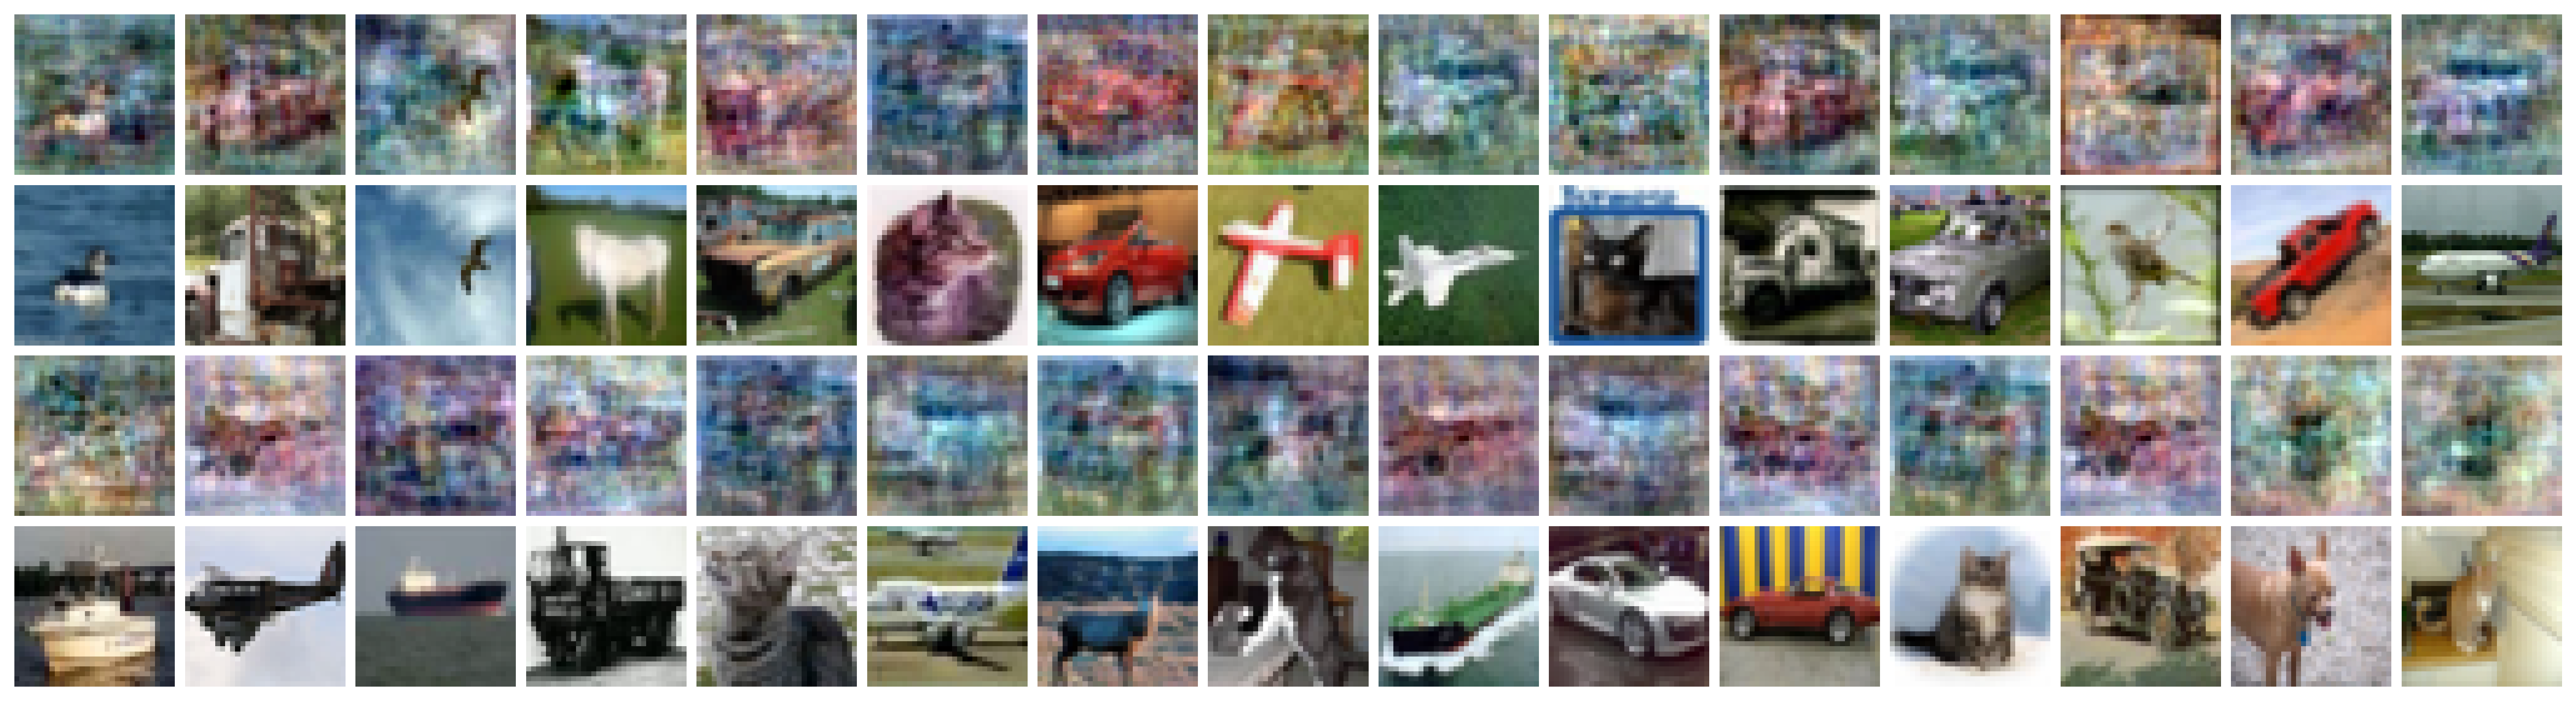

DONE!
Reconstruction visualization of model trained with normalized data
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_03_22_26_07_625868_test_data_norm/figures/vis_best_reco_of_norm_seed_622_run.png


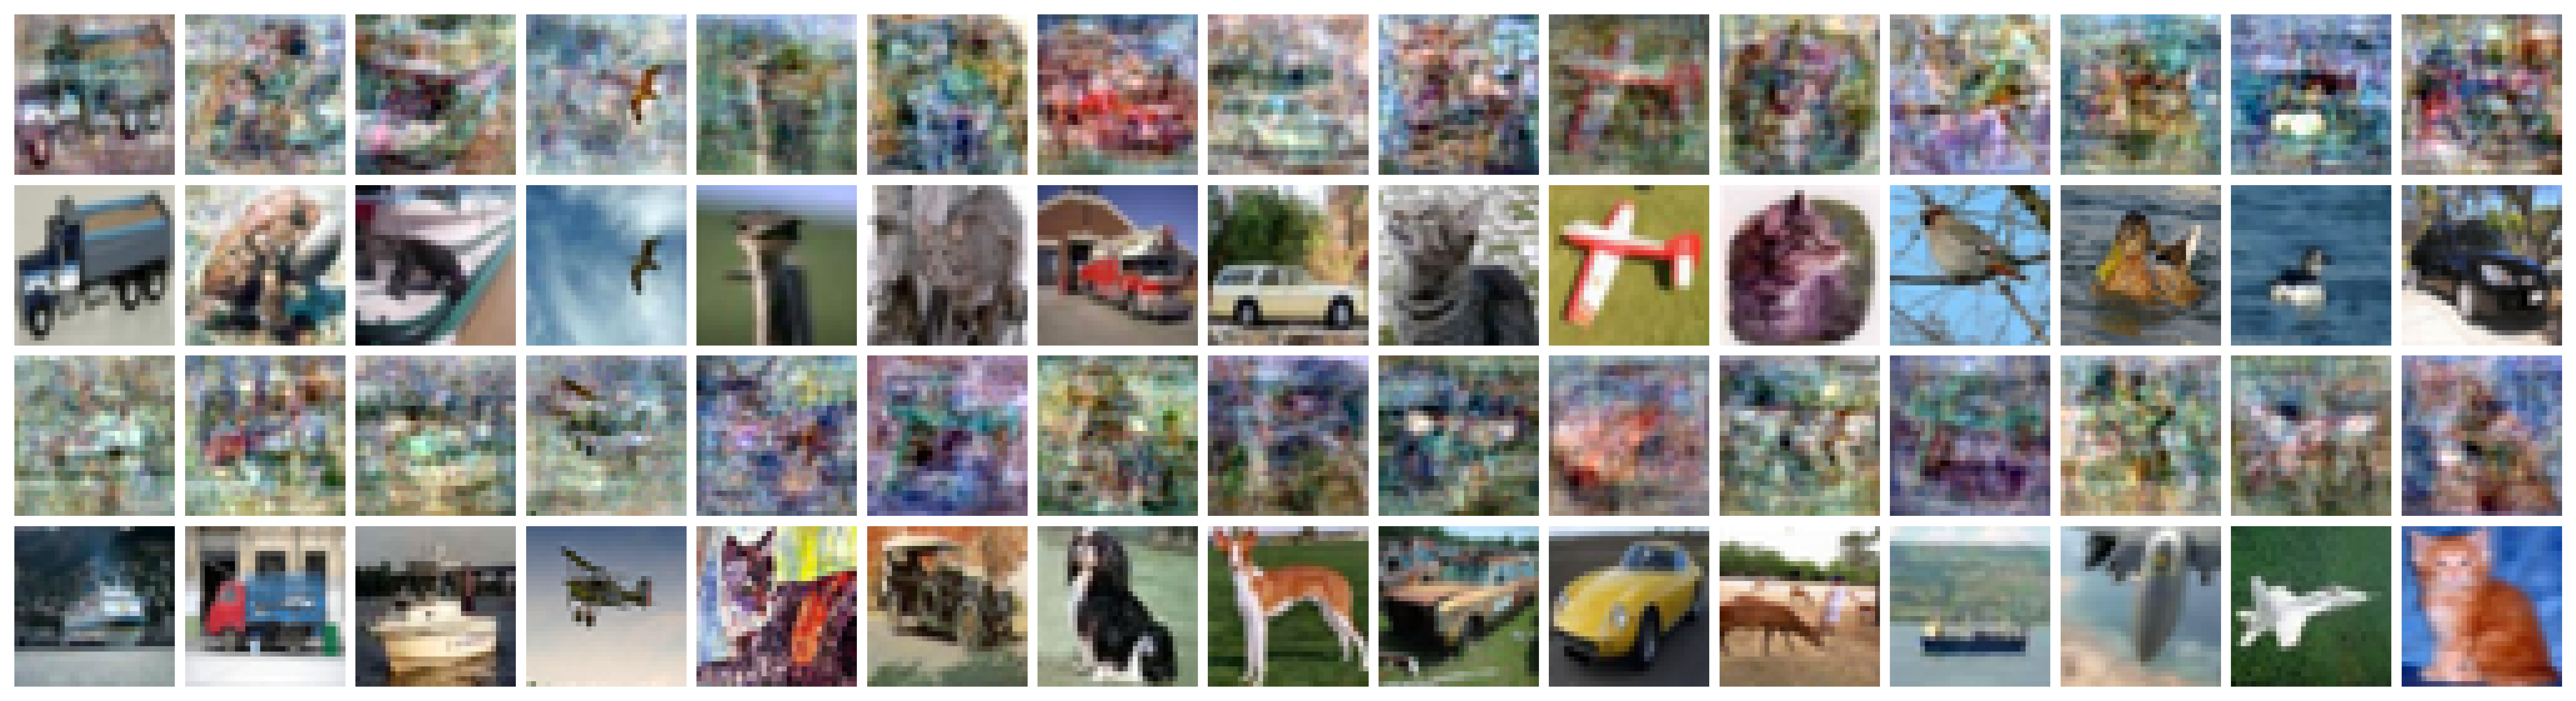

DONE!
loaded test.args.seed = 623
Reconstruction visualization of model trained with data without normalization
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_03_23_16_13_243288_test_data_norm/figures/vis_best_reco_of_orig_seed_623_run.png


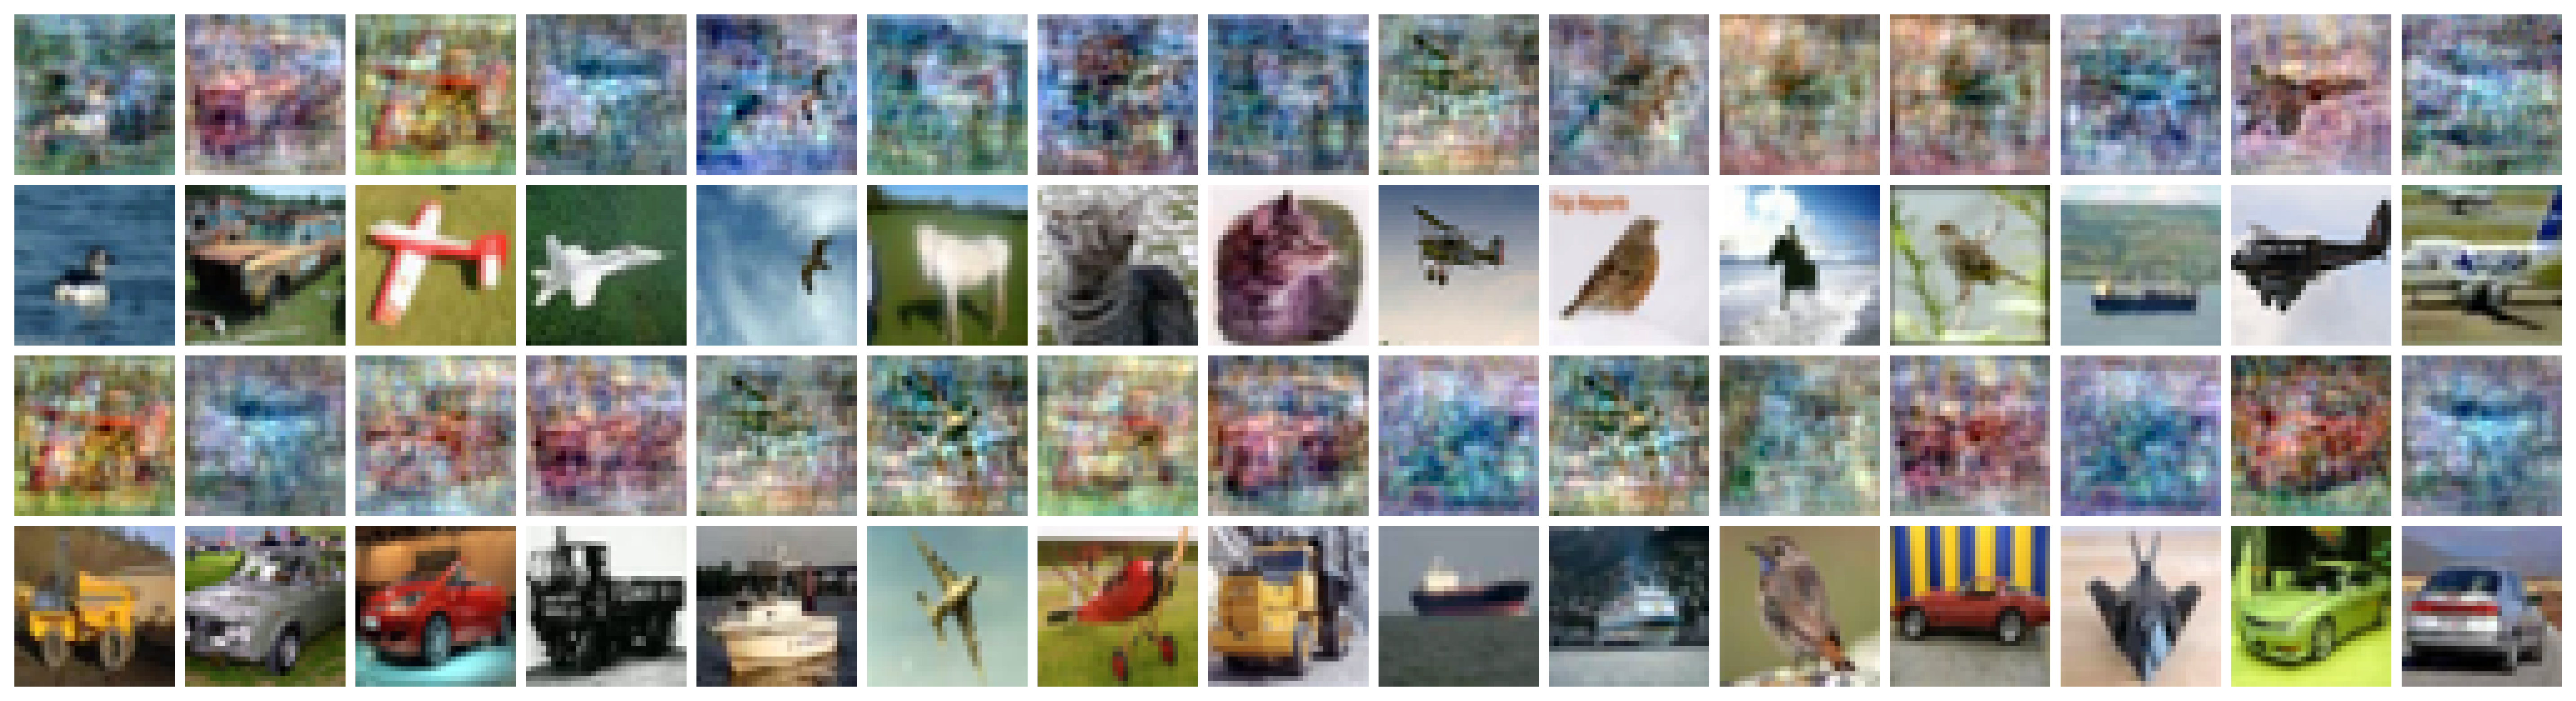

DONE!
Reconstruction visualization of model trained with normalized data
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_03_23_16_13_243288_test_data_norm/figures/vis_best_reco_of_norm_seed_623_run.png


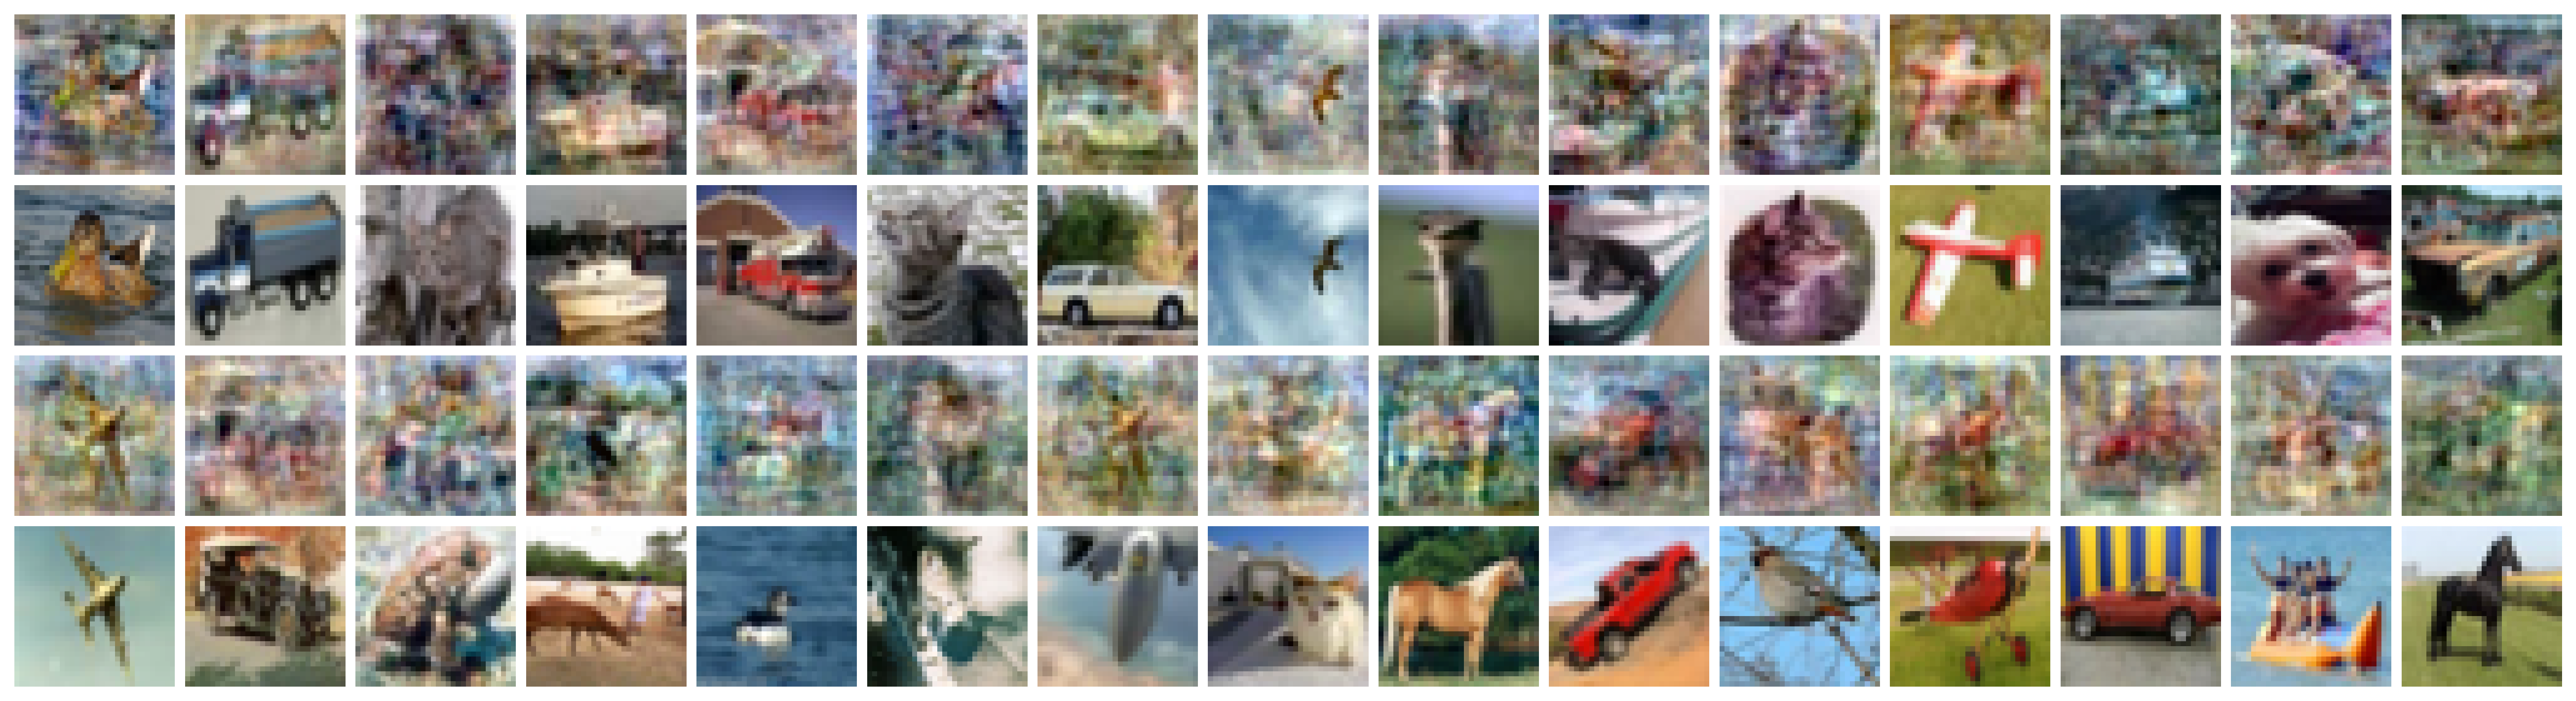

DONE!
loaded test.args.seed = 624
Reconstruction visualization of model trained with data without normalization
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_04_00_06_07_933379_test_data_norm/figures/vis_best_reco_of_orig_seed_624_run.png


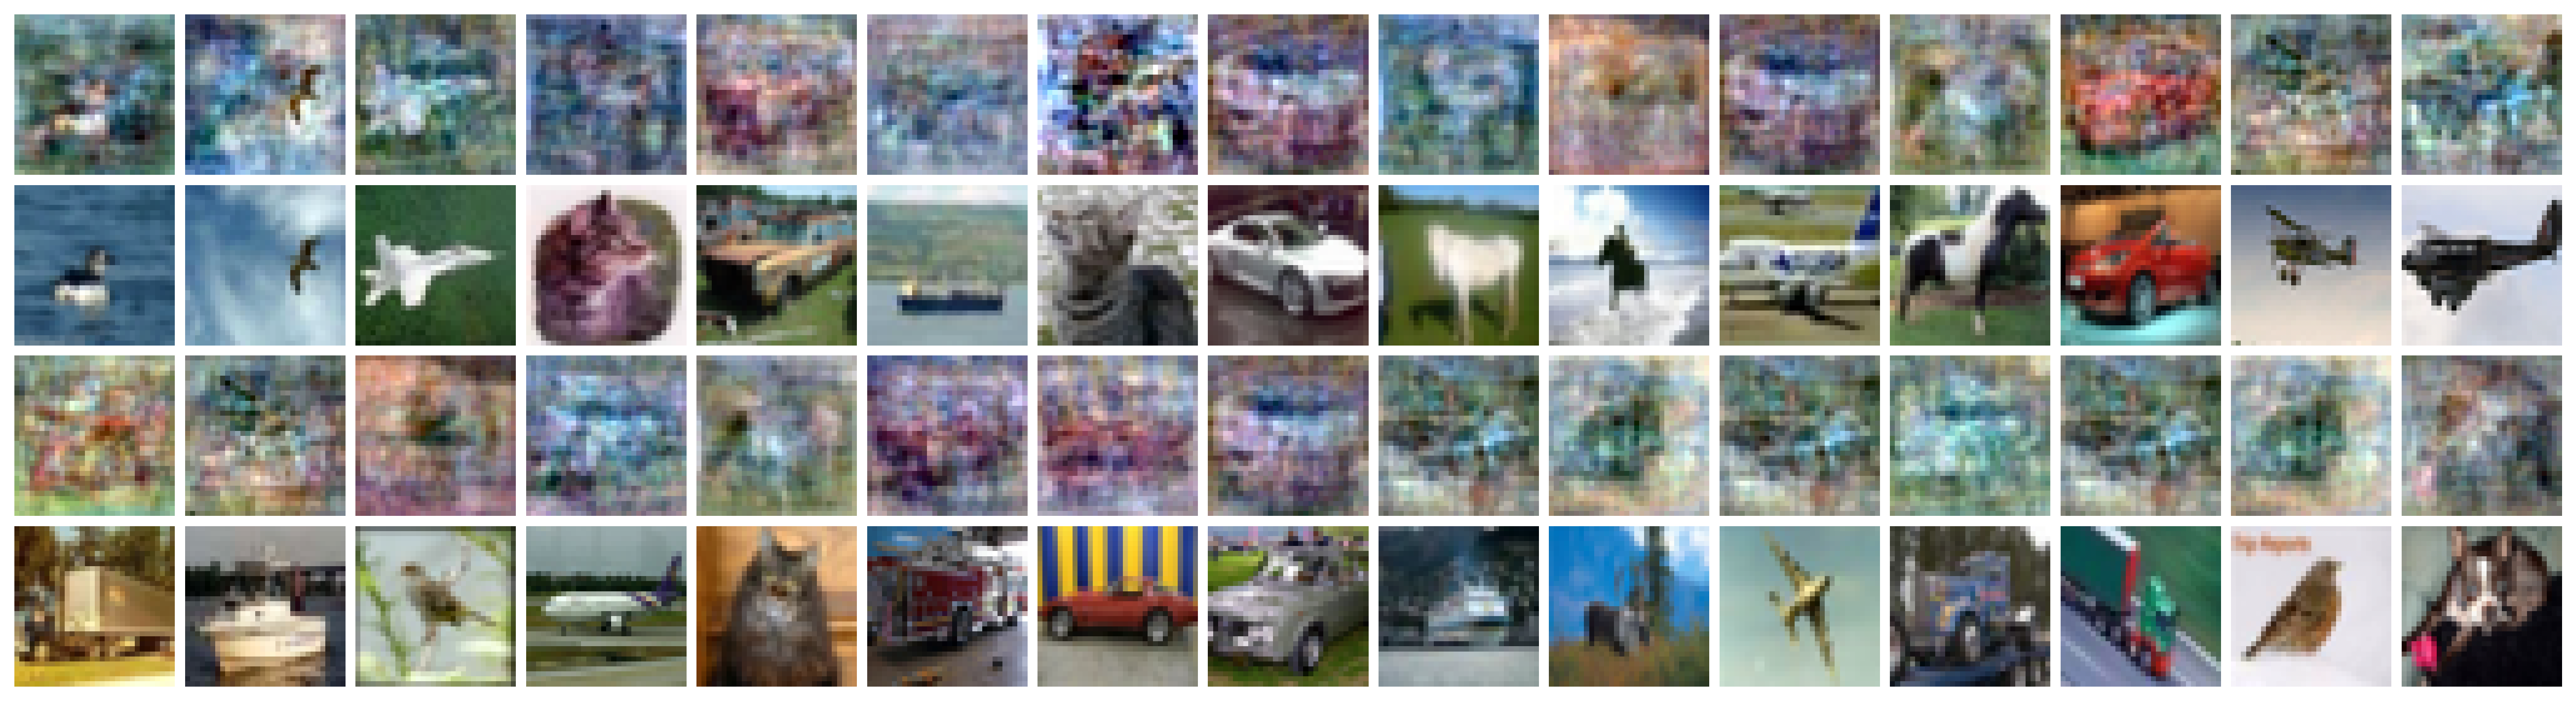

DONE!
Reconstruction visualization of model trained with normalized data
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_04_00_06_07_933379_test_data_norm/figures/vis_best_reco_of_norm_seed_624_run.png


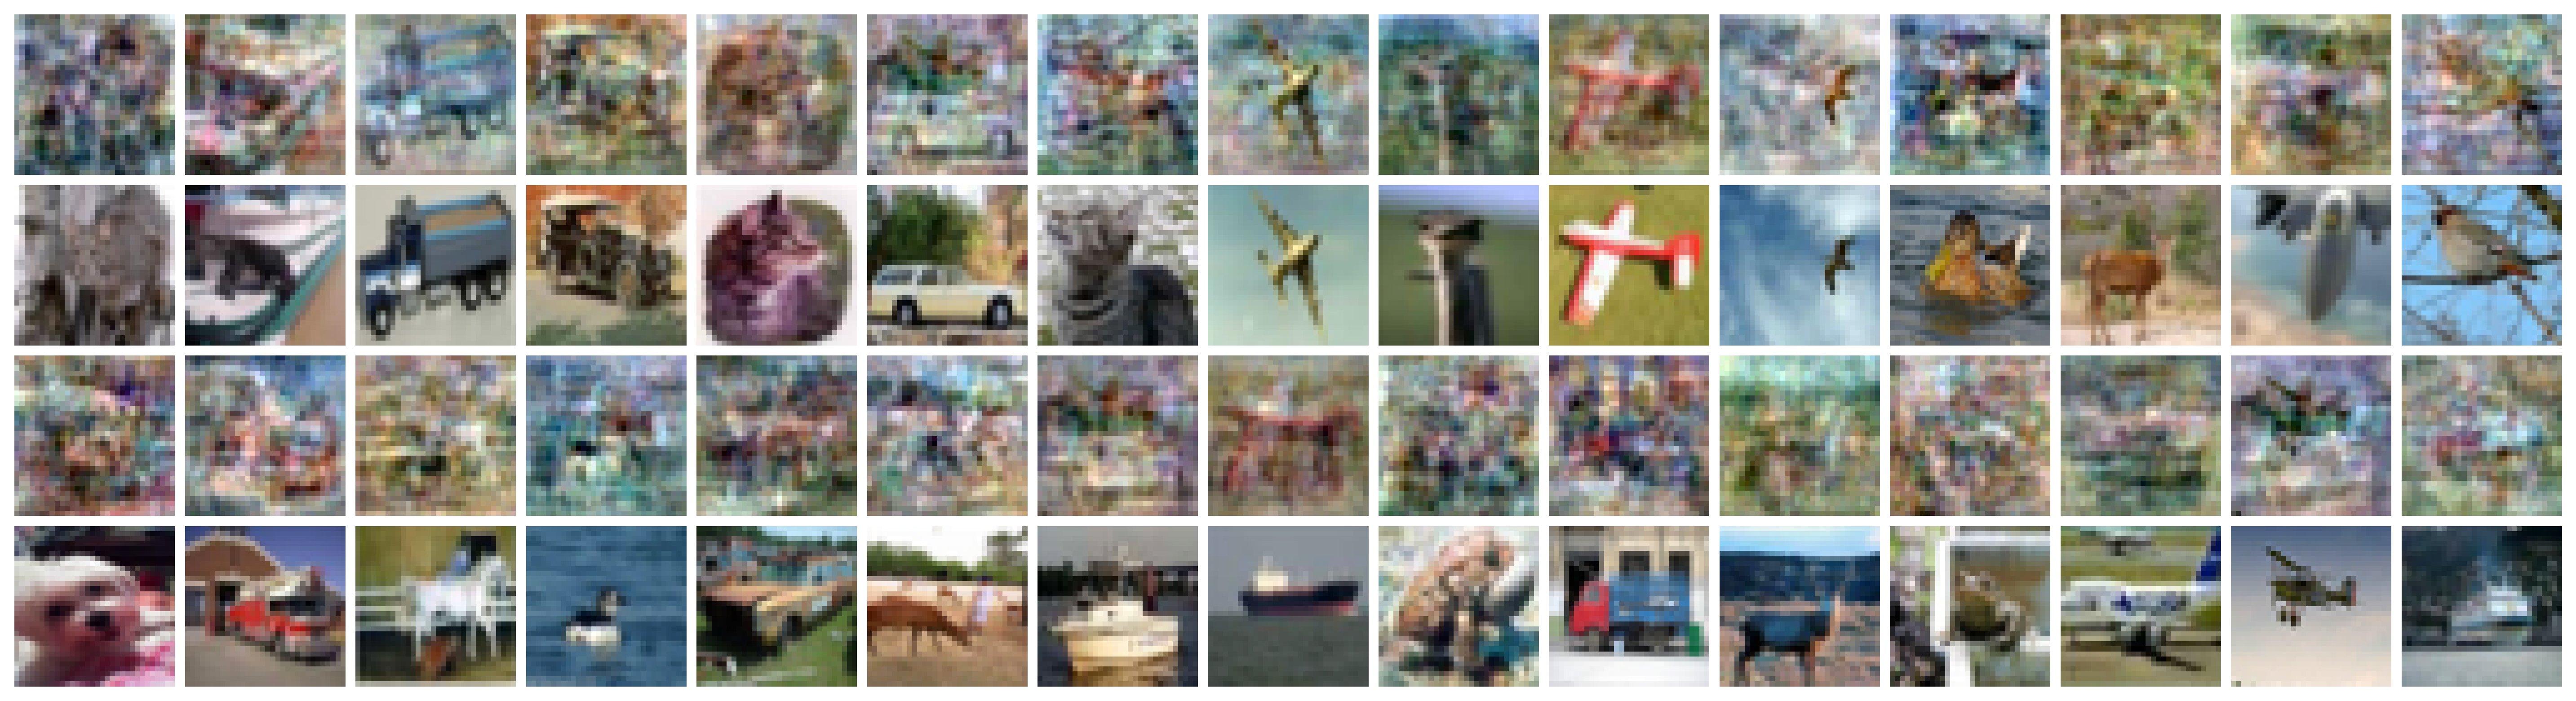

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with data without normalization
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_05_21_47_17_985102_test_data_norm/figures/vis_best_reco_of_orig_seed_621_run.png


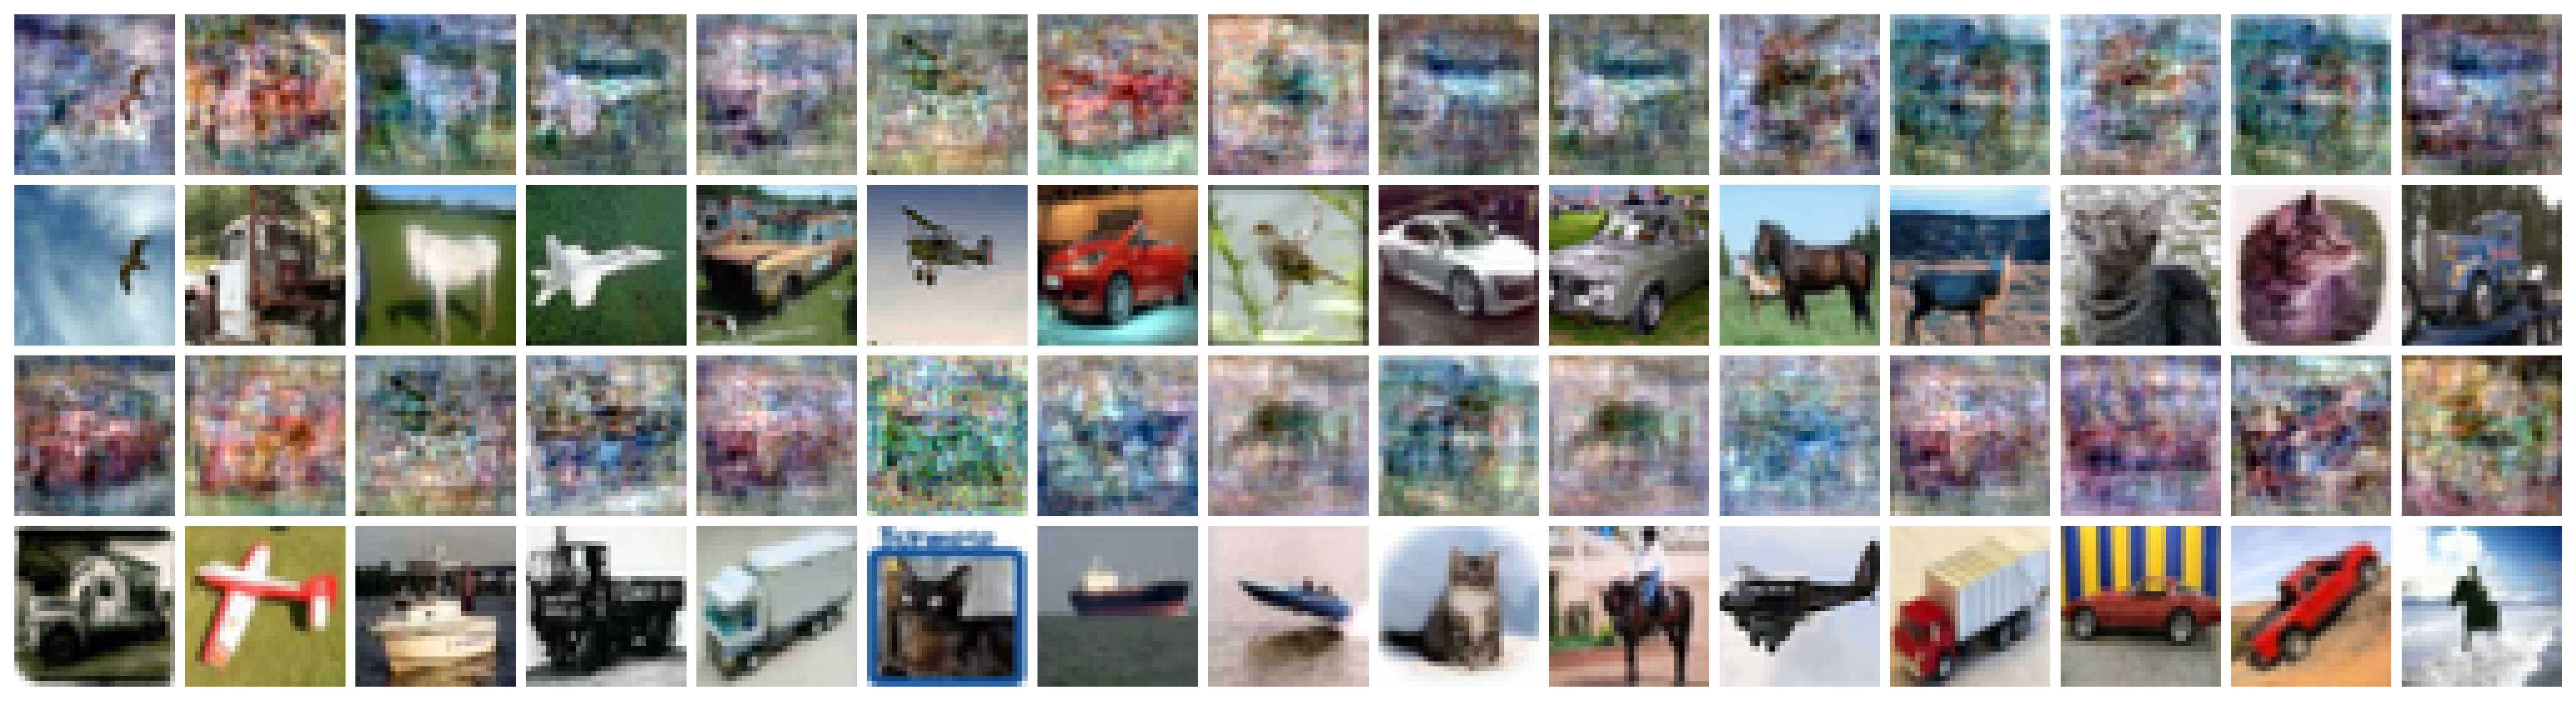

DONE!
Reconstruction visualization of model trained with normalized data
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_05_21_47_17_985102_test_data_norm/figures/vis_best_reco_of_norm_seed_621_run.png


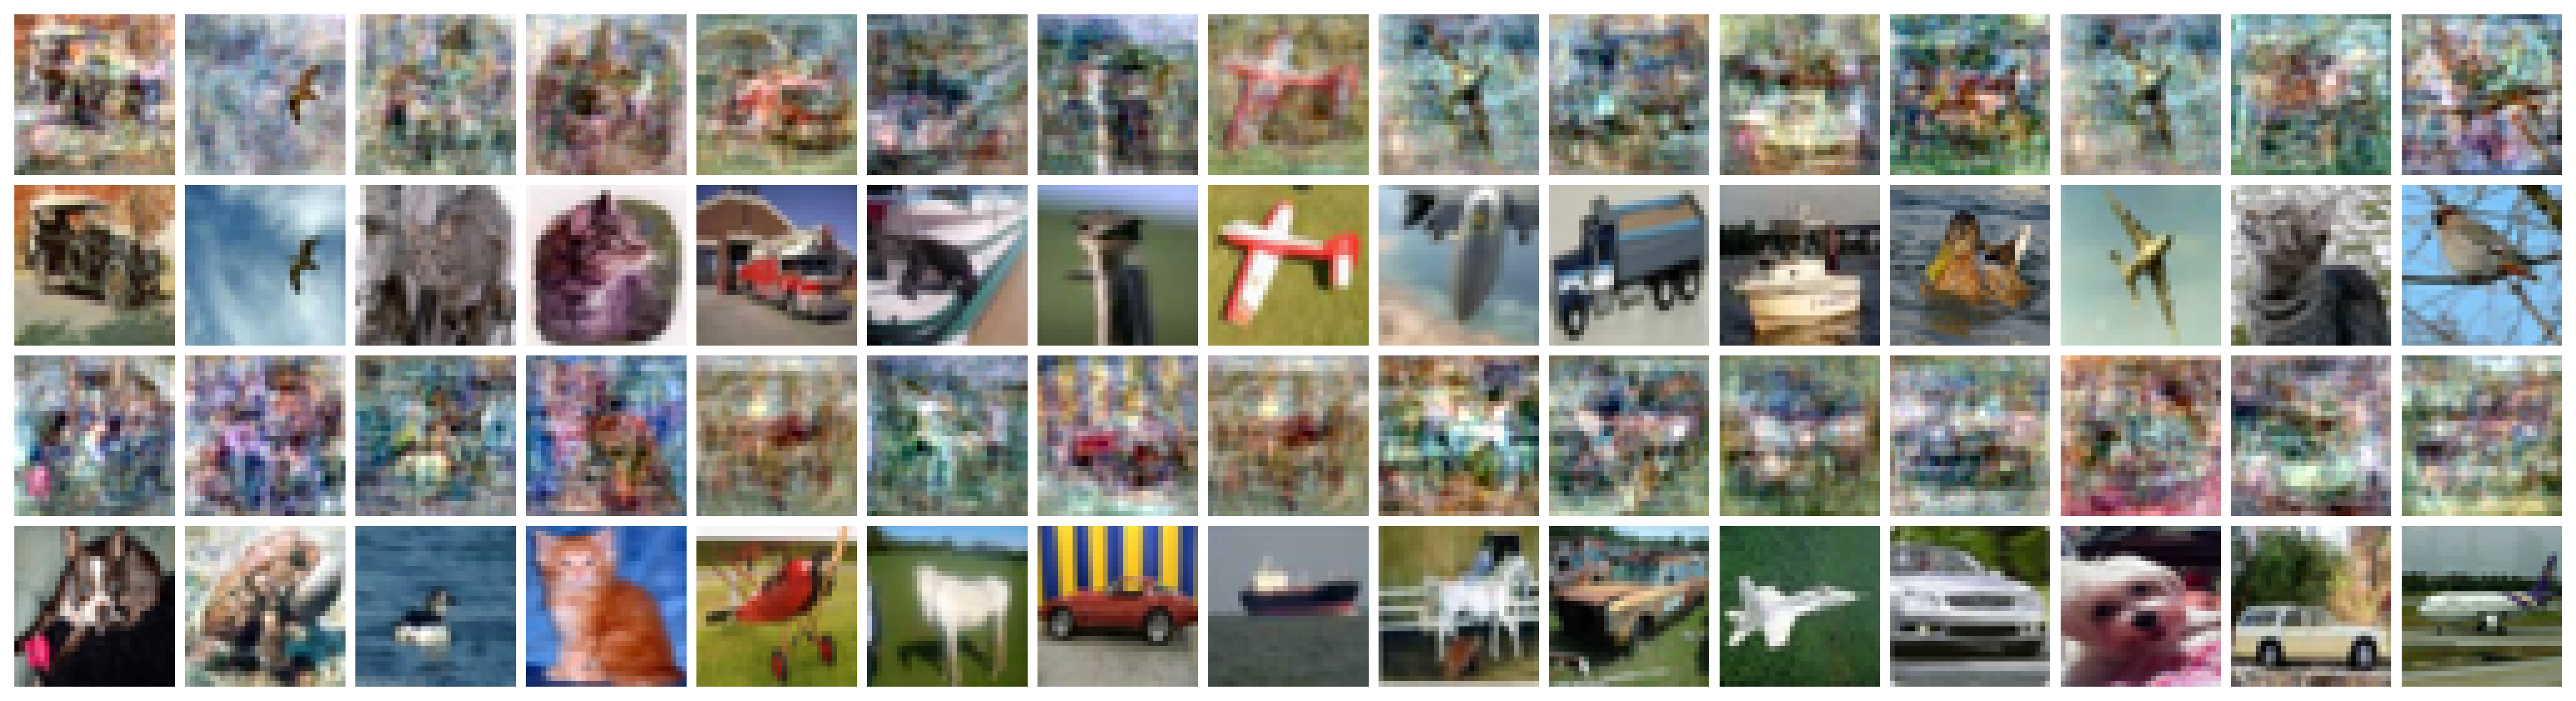

DONE!


NameError: name 'stop' is not defined

In [ ]:
# Visualizing reconstructions:
##############################
# Checking for 4 seeds if the hyperparameters results in "good teconstructions"
#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#plot_reco(loaded_test_folder)

loaded_test_folder    = '08_03_22_26_07_625868_test_data_norm'
plot_reco(loaded_test_folder, save = True)

loaded_test_folder    = '08_03_23_16_13_243288_test_data_norm'
plot_reco(loaded_test_folder, save = True)

loaded_test_folder    = '08_04_00_06_07_933379_test_data_norm'
plot_reco(loaded_test_folder, save = True)

loaded_test_folder    = '08_05_21_47_17_985102_test_data_norm'
plot_reco(loaded_test_folder, save = True)
stop

In [ ]:
# Getting the data of orig reconstruction
# orig_last_epoch_x.pth
reco_type = 'orig'
f_name = f'{reco_type}_last_epoch_x.pth'
loaded_recon_dict = test.load_recon_variables(f_name)
saved_format = loaded_recon_dict['map_location']
x_rec_orig   = loaded_recon_dict['var']
print(f'type = {type(x_rec_orig)}; {x_rec_orig.shape} ')

# loaded before the reconstruction
print(f'type = {type(x_trn_orig)}; {x_trn_orig.shape} ')

model = test.model_orig

# tensor of '0'
norm = x_trn_orig.mean(dim=0, keepdims=True) * 0

In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(x_rec_orig, x_trn_orig, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images (when visualizing 'orig' we do not reverse normalizarion)
xx_scaled, yy_scaled = scale(xx1, x_trn_orig, ds_mean = norm, xx_add_ds_mean = False)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(x_trn_orig).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

**Observation**:

When training 10 epochs and reconstructing 50 epochs, we get reconstructions that are very similar to the normalization, that is, to the mean of the features.

it also looks the same in 200,000 epochs of training.

In [ ]:
# Getting the data of norm reconstruction
# norm_last_epoch_x.pth
reco_type = 'norm'
f_name = f'{reco_type}_last_epoch_x.pth'
loaded_recon_dict = test.load_recon_variables(f_name)
saved_format = loaded_recon_dict['map_location']
x_rec_norm   = loaded_recon_dict['var']
print(f'type = {type(x_rec_norm)}; {x_rec_norm.shape} ')

#x_trn_norm = test.x_trn_norm
print(f'type = {type(x_trn_norm)}; {x_trn_norm.shape} ')

model = test.model_norm

# recomputing the normaliztion
norm = x_trn_orig.mean(dim=0, keepdims=True)

In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour (see 'analysis.py')
xx1 = find_nearest_neighbour(x_rec_norm, x_trn_norm, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images (see 'analysis.py')
xx_scaled, yy_scaled = scale(xx1, x_trn_norm, ds_mean = norm, xx_add_ds_mean = True)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(x_trn_norm).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)